# Song Recognizer vol. 1.2

Convolutional Neural Network for classifying genre of a given audio sample. Training data consists of 1000 audio samples of 10 different genres and 4000 created by distorting original MFCC samples. The accuracy of the model is at the level of 96%.

TODO: implement other methods of distorting audio samples

In [417]:
# imports and settings
import keras
import numpy as np
import librosa
import librosa.display
import IPython
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

# visualization
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams['figure.figsize'] = (10,4)

In [2]:
# labels used
LABELS = {'blues':0,'classical':1,'country':2,'disco':3,'hiphop':4,'jazz':5,'metal':6,'pop':7,'reggae':8,'rock':9}

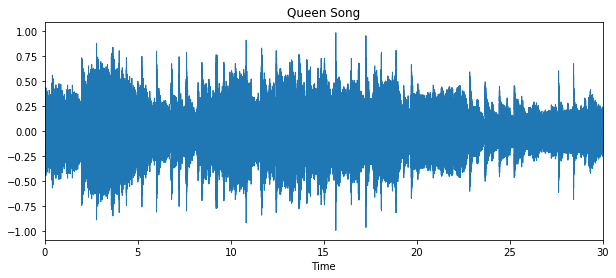

In [411]:
# load sample
x, fs = librosa.load(r'genres\rock\rock.00023.wav')

# display sample
plt.title('Queen Song')
librosa.display.waveplot(x, sr=fs)
plt.show()

# play sample
IPython.display.Audio(x, rate=fs)

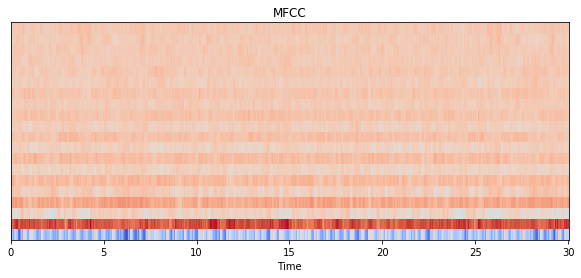

In [67]:
# mfcc of sample
mfccs = librosa.feature.mfcc(x, sr=fs)

# display mfcc
plt.title('MFCC')
librosa.display.specshow(mfccs, sr=fs, x_axis='time')
plt.show()

In [125]:
def create_dataset(path='genres', labels=LABELS, cut=25000, convert=True, 
                   feature_scaling=True, augmentation=5, random_state=None):
    
    '''
    function used to create dataset
    
    path:            path to samples
    labels:          labels used
    cut:             maximum size of sample
    convert:         extract MFCC
    feature_scaling: scale samples to [-1, 1]
    random_state:    used to shuffle
    '''
    
    # songs and labels
    X, y = [], []
    
    # iterate over .way files
    for dirpath, _, files in tqdm(os.walk(path), total=len(LABELS)):
        for file in files:
            if file.endswith('.wav'):
                x = os.path.join(dirpath, file)
                song, fs = librosa.load(x)
                
                # extract MFCC
                if convert:
                    song = librosa.feature.mfcc(song, sr=fs)
                    
                # scale
                if feature_scaling:
                    if len(song.shape) == 1:
                        song = song.reshape(-1, 1)
                    scaler = MinMaxScaler(feature_range=(-1, 1))
                    song = scaler.fit_transform(song)
                    
                # append song and label to datasets 
                genre = file.split('.')[0]
                
                # generate additional smaples
                if augmentation and feature_scaling:
                    for i in range(augmentation):
                        aug_song = song.copy()
                        
                        # choose size of stripes
                        size1 = np.random.randint(2, 5)
                        size2 = np.random.randint(70, 121)
                        
                        # choose col and row
                        cols = np.random.randint(0, song.shape[0]-size1)
                        rows = np.random.randint(0, song.shape[1]-size2)
                        
                        # distort sample
                        aug_song[cols:cols+size1] = 0
                        aug_song[rows:rows+size2] = 0
                        
                        # cut sample to max size
                        if cut:
                            X.append(aug_song.flatten()[:cut])
                        else:
                            X.append(song.flatten())
                            
                        # append label
                        y.append(labels[genre])
                
    # convert label strings to actual classes
    Y = keras.utils.to_categorical(y)
    
    # shuffle with given seed
    X, Y = shuffle(X, Y, random_state=random_state)
    
    return np.array(X), np.array(Y)

In [126]:
# generate dataset
x_data, y_data = create_dataset(random_state=2018)

total: 5000


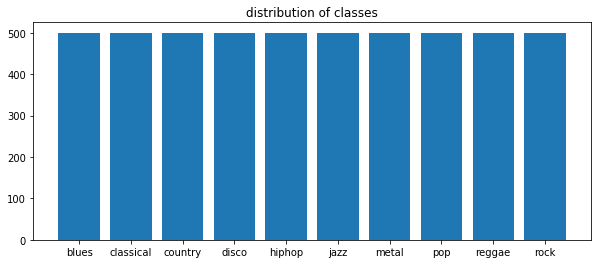

In [184]:
# distribution of target classes
heights = np.sum(y_data, axis=0)
plt.title('distribution of classes')
plt.bar(LABELS.keys(), heights)
plt.plot()
print('total:', len(x_data))

# Perfectly balanced, as all things should be

In [128]:
# split data for training and testing datasets
train_size = 0.8
split = int(len(x_data) * train_size)
x_train, x_test = x_data[:split], x_data[split:]
y_train, y_test = y_data[:split], y_data[split:]

In [129]:
# reshape to 3D 
x_tr_reshaped = x_train.reshape((len(x_train), -1, 1))
x_te_reshaped = x_test.reshape((len(x_test), -1, 1))

In [298]:
# create model in keras
inputs = keras.layers.Input(shape=x_tr_reshaped.shape[1:], dtype='float32')
x = keras.layers.Conv1D(16, 5, padding="valid", activation="relu", strides=5)(inputs)
x = keras.layers.Conv1D(32, 5, padding="valid", activation="relu", strides=5)(x)
x = keras.layers.Conv1D(64, 5, padding="valid", activation="relu", strides=5)(x)
x = keras.layers.Conv1D(128, 5, padding="valid", activation="relu", strides=5)(x)
x = keras.layers.Conv1D(256, 5, padding="valid", activation="relu", strides=5)(x)
x = keras.layers.MaxPooling1D()(x)
x = keras.layers.Dropout(0.5)(x)
# x = keras.layers.Dense(128, activation="relu")(x)
# x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)

# compile model
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [299]:
# model statistics
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 25000, 1)]        0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 5000, 16)          96        
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 1000, 32)          2592      
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 200, 64)           10304     
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 40, 128)           41088     
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 8, 256)            164096    
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 4, 256)            0  

In [300]:
# training phase
history = model.fit(x_tr_reshaped, y_train,
                   batch_size=10,
                   epochs=15,
                   shuffle=True, 
                   validation_split=0.2)

Epoch 1/15
320/320 [==============================] - 6s 19ms/step - loss: 2.1104 - accuracy: 0.2249 - val_loss: 1.6428 - val_accuracy: 0.3875
Epoch 2/15
320/320 [==============================] - 6s 18ms/step - loss: 1.5447 - accuracy: 0.4589 - val_loss: 1.2971 - val_accuracy: 0.5200
Epoch 3/15
320/320 [==============================] - 6s 18ms/step - loss: 1.3653 - accuracy: 0.5109 - val_loss: 1.2047 - val_accuracy: 0.5550
Epoch 4/15
320/320 [==============================] - 6s 18ms/step - loss: 1.1344 - accuracy: 0.5889 - val_loss: 0.9859 - val_accuracy: 0.6438
Epoch 5/15
320/320 [==============================] - 6s 18ms/step - loss: 0.8957 - accuracy: 0.6824 - val_loss: 0.7111 - val_accuracy: 0.7487
Epoch 6/15
320/320 [==============================] - 6s 19ms/step - loss: 0.6213 - accuracy: 0.7793 - val_loss: 0.6281 - val_accuracy: 0.7987
Epoch 7/15
320/320 [==============================] - 6s 18ms/step - loss: 0.4220 - accuracy: 0.8576 - val_loss: 0.3740 - val_accuracy: 0.8700

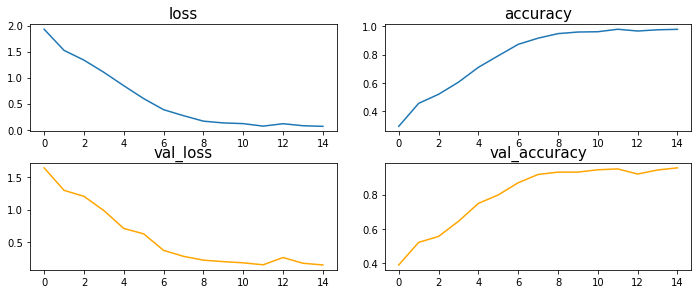

In [301]:
# plot loss and accuracy during training phase
fig, axs = plt.subplots(2, 2)
fig.tight_layout()
axs[0,0].set_title('loss', fontsize=15)
axs[0,0].plot(history.history['loss'])

axs[0,1].set_title('accuracy', fontsize=15)
axs[0,1].plot(history.history['accuracy'])

axs[1,0].set_title('val_loss', fontsize=15)
axs[1,0].plot(history.history['val_loss'], color='orange')

axs[1,1].set_title('val_accuracy', fontsize=15)
axs[1,1].plot(history.history['val_accuracy'], color='orange')
plt.show()

In [302]:
loss, acc = model.evaluate(x_te_reshaped, y_test)

32/32 [==============================] - 1s 14ms/step - loss: 0.1829 - accuracy: 0.9560


In [303]:
print(f'model test loss:\t{round(loss, 4)}\n'
      f'model accuracy:\t\t{round(acc, 4)}')

model test loss:	0.1829
model accuracy:		0.956


In [305]:
# calculate confusion matrix
y_pred = model.predict(x_te_reshaped)
actual = np.argmax(y_test, axis=1)
predicted = np.argmax(y_pred, axis=1)
matrix = confusion_matrix(actual, predicted)

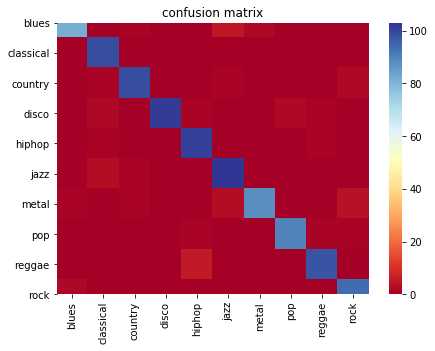

conf matrix:


array([[ 82,   0,   1,   0,   0,   5,   2,   0,   0,   0],
       [  0,  99,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,  99,   0,   0,   1,   0,   0,   0,   2],
       [  0,   2,   0, 102,   1,   0,   0,   2,   1,   0],
       [  0,   1,   0,   0, 101,   0,   0,   0,   1,   0],
       [  0,   3,   1,   0,   0, 103,   0,   0,   0,   0],
       [  1,   0,   1,   0,   0,   3,  88,   0,   0,   4],
       [  0,   0,   0,   0,   1,   0,   0,  90,   1,   1],
       [  0,   0,   0,   0,   6,   0,   0,   0,  98,   0],
       [  2,   0,   0,   0,   0,   0,   0,   0,   0,  94]], dtype=int64)

In [306]:
# plot confusion matrix
plt.figure(figsize=(7,5))
plt.title('confusion matrix')
sns.heatmap(matrix, xticklabels=LABELS.keys(), yticklabels=LABELS.keys(), cmap='RdYlBu')
plt.show()

print('conf matrix:')
matrix

In [307]:
# scores of the model on different classes
scores = classification_report(actual, predicted)
print(scores)

              precision    recall  f1-score   support

           0       0.96      0.91      0.94        90
           1       0.93      1.00      0.97        99
           2       0.97      0.96      0.97       103
           3       1.00      0.94      0.97       108
           4       0.93      0.98      0.95       103
           5       0.92      0.96      0.94       107
           6       0.98      0.91      0.94        97
           7       0.98      0.97      0.97        93
           8       0.97      0.94      0.96       104
           9       0.93      0.98      0.95        96

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



In [396]:
# create model for visualization purposes
vis_input = model.input
vis_output = model.get_layer(index=-4).output
vis_model = keras.Model(inputs=vis_input, outputs=vis_output)

# predidct and reshape to 2d since pca requires 2d input
vis_data = vis_model.predict(x_te_reshaped).reshape(len(x_te_reshaped), -1)

In [406]:
# reduce dimensionality to 50
pca = PCA(n_components=50)
vis_data50d = pca.fit_transform(vis_data)

# further reduce dimensionality
tsne = TSNE(n_components=2)
vis_data2d = tsne.fit_transform(vis_data50d)

In [407]:
# create colormap for scatter plot
cmap = cm.rainbow(np.linspace(0.0, 1.0, len(LABELS)))
colors = cmap[predicted]

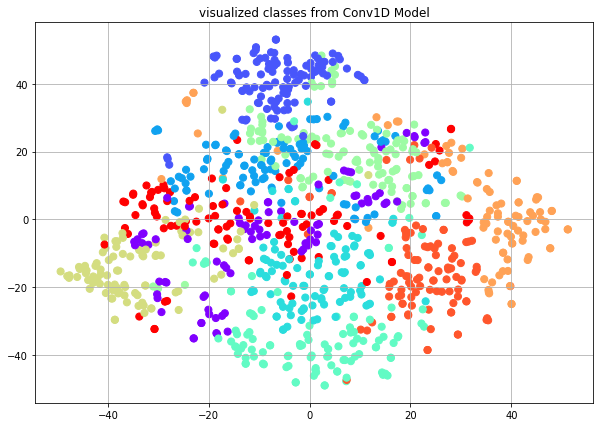

In [415]:
# plot classes representation in 2d space
plt.figure(figsize=(10,7))
plt.title('visualized classes from Conv1D Model')
plt.scatter(vis_data2d[:, 0], vis_data2d[:, 1], color=colors, s=50)
plt.grid(True)
plt.show()

# somehow grouped